Self Organising Maps Tutorial http://blog.yhat.com/posts/self-organizing-maps-2.html

In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import os

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

PATH = os.path.abspath(os.path.join('drive', 'My Drive', 'engr489-2019', 'kun', 'models'))
sys.path.append(PATH)

# OUTPUT_DIR = PATH+'/ae_hdbscan_v1_2019.04.09-11:54:40_output'
# print(OUTPUT_DIR)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Dataset
Dataset of 100 random RGB values - 100 3D vectors from 0-255.

In [2]:
import numpy as np

raw_data = np.random.randint(0, 255, (2000, 3))

raw_data.shape

(2000, 3)

### Objective
Taking 3D colour vectors and mapping them to 2D surface so similar colours will end up in same area of 2D surface.



### SOM Parameters
- SOM Size: Dimensionality (2D) and number of neurons in the grid. This is decided through trial and error. We should use fewer neurons than datapts there may be no overlap. Each of the 2D pts represents a 3D weight vector associates with the same number of dimensions as input. eg. 3D weight vector for 3 dim input

- Learning Parameters:
    - Number of iterations: for small example, 2000 suffices, big examples >10 000
    - Radius decay: the initial 2D radius will encompass most of the SOM and will gradually decrease as the number of iterations increases.
    - Learning rate: decides how much we apply changes to SOM at each iter
    - Learning rate decay: how much the lr should decay over time

In [15]:
network_dimensions = np.array([10, 20])
n_iterations = 2000
init_learning_rate = 0.01
# establish size variables based on data

n = raw_data.shape[0]
m = raw_data.shape[1]
print(n, m)

# weight matrix (i.e. the SOM) needs to be one m-dimensional vector for each neuron in the SOM
# setup random weights between 0 and 1
net = np.random.random((network_dimensions[0], network_dimensions[1], m))
print(net.shape)

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

2000 3
(10, 20, 3)


### Normalisation



In [0]:
# we want to keep a copy of the raw data for later
data = raw_data

# normalise
data = raw_data / data.max()

### Learning

For a single iteration:

- Find the neuron in the SOM whose associated 3D vector is closest to our chosen 3D colour vector. At each step, this is called the Best Matching Unit (BMU)
- Move the BMU’s 3D weight vector closer to the input vector in 3D space
- Identify the 2D neighbours of the BMU and also move their 3D weight vectors closer to the input vector, although by a smaller amount
- Update the learning rate (reduce it at each iteration)

In [0]:
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

In [0]:
for i in range(n_iterations):
  
#     print('Iteration %d' % i)
    
    # select a training example at random
    t = data[np.random.randint(0, n), :].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # update weight vector to move closer to input
    # and move its neighbours in 2-D vector space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            
            # w_dist = np.sqrt(w_dist)
            
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                net[x, y, :] = new_w.reshape(1, 3)

In [13]:
# centroids = np.zeros(shape=(1, net.shape[2]))
# print(centroids.shape)
# for x in range(1, net.shape[0] + 1):
#         for y in range(1, net.shape[1] + 1):
#             print(net[x-1, y-1, :].shape)
#             centroids = np.concatenate(centroids, np.array(net[x-1, y-1, :]))
# centroids.shape


centroids = np.array([ net[x-1, y-1, :] for x in range(net.shape[0]) for y in range(net.shape[1]) ])
centroids.shape

(200, 3)

0 0 [0.29235001 0.410739   0.72566347]
0 1 [0.23299773 0.28371886 0.66685318]
0 2 [0.24679232 0.28431012 0.5701222 ]
0 3 [0.28211098 0.38974496 0.5750659 ]
0 4 [0.26983369 0.32727257 0.43699935]
0 5 [0.31351602 0.39322472 0.3883532 ]
0 6 [0.32452095 0.46507669 0.31740113]
0 7 [0.24794762 0.3742182  0.26787686]
0 8 [0.26616801 0.44712896 0.34251657]
0 9 [0.35623006 0.41797913 0.3272779 ]
1 0 [0.21280862 0.41840566 0.68805703]
1 1 [0.21307732 0.33000931 0.64478668]
1 2 [0.28492045 0.39170028 0.57893526]
1 3 [0.30059781 0.38364462 0.55362801]
1 4 [0.28627024 0.37070767 0.42744625]
1 5 [0.24573885 0.46081943 0.37482673]
1 6 [0.28065208 0.40683668 0.35873944]
1 7 [0.26860741 0.40815038 0.25926147]
1 8 [0.32083091 0.46389779 0.29257543]
1 9 [0.31446231 0.43179894 0.32183893]
2 0 [0.33773646 0.47198813 0.68415347]
2 1 [0.22368117 0.4544572  0.64182409]
2 2 [0.23043707 0.47695712 0.61629433]
2 3 [0.26541833 0.41363292 0.53244933]
2 4 [0.25125524 0.44204227 0.49919812]
2 5 [0.27821298 0.5129004

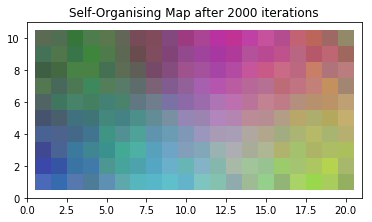

In [14]:
from matplotlib import pyplot as plt
from matplotlib import patches as patches


fig = plt.figure()

ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        print(x-1,y-1, net[x-1,y-1,:])
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()